<span style="color:gray">
Copyright &copy; 2020-2021 by Fraunhofer-Gesellschaft. All rights reserved.<br>
Fraunhofer Institute for Integrated Circuits IIS, Division Engineering of Adaptive Systems EAS<br>
Münchner Straße 16, 01187 Dresden, Germany
</span>

---

## ESB - Energy Saving by Blockchain

Eurostars – EXP 00119832 / EUS-2019113348

---

## Prediction of Energy Consumption for Variable Customer Portfolios Including Aleatoric Uncertainty Estimation

*Oliver Mey, André Schneider, Olaf Enge-Rosenblatt, Yesnier Bravo, Pit Stenzel*

The notebook is part of a paper submission contributed to the **10th International Conference on Power Science and Engineering (ICPSE 2021)** will be held on Oct. 21-23, 2021 in Yildiz Technical University, Istanbul, Turkey.

---

# C1: Model Training

This notebook loads the available datasets, splits the datasets into three subsets for training, test and validation, fits the scalers and encoders for feature extraction, extracts the features for all subsets, and trains the prediction model. Finally, selected prediction results for a single customers as well as for customer groups (portfolios) are plotted. 

---

<span style="color:gray">
Version 0.4.16 (October 13, 2021)<br>
Authors: Oliver Mey, André Schneider (Fraunhofer IIS)<br>
</span>    

In [1]:
import warnings, logging, os
warnings.filterwarnings('ignore')
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import os
import joblib
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays as hd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.layers import Dense, LeakyReLU, LSTM, GRU, Dropout, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Reshape, Lambda, Concatenate
from tensorflow.keras.layers import TimeDistributed, Input, GlobalAveragePooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.models import load_model
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from datetime import datetime

%matplotlib inline
sns.set(rc={'figure.figsize':(16, 6)})

### Configuration

In [3]:
path = '..'
timezone = 'Europe/Madrid'
seed = 12345
epsilon = 1e-5
quantiles = [0.5, 0.15865, 0.84135]
epochs = 40
batch_size = 32
learning_rate = 0.00005
skip = 15

In [4]:
properties = {
    'data_path' : path + '/data',
    'models_path' : path + '/models/C1_01',
    't_consumption_daily': [-14, -1],
    't_consumption_hourly': [-7, -1],
    't_weather_daily': [-13, 0],
    't_weather_hourly': [-2, 0],
    'epsilon': epsilon
}

### Function Definitions

In [5]:
def fix_DST(data):
    data = data[~data.index.duplicated(keep='first')]
    data = data.resample('H').ffill()
    return data

def crop(data):
    hour_index = data.index.hour
    t0 = data[hour_index==0].head(1).index
    tn = data[hour_index==23].tail(1).index
    data.drop(data.loc[data.index < t0[0]].index, inplace=True)
    data.drop(data.loc[data.index > tn[0]].index, inplace=True)
    return

def time_from_to(date, t):
    t0_ = pd.Timestamp(date)+pd.Timedelta(days=t[0])
    tn_ = pd.Timestamp(date)+pd.Timedelta(days=t[1])+pd.Timedelta(hours=23)
    return slice(t0_, tn_)

def day_from_to(date, t):
    t0_ = pd.Timestamp(date)+pd.Timedelta(days=t[0])
    tn_ = pd.Timestamp(date)+pd.Timedelta(days=t[1])
    return slice(t0_, tn_)

def softrange(x, x_min=0, x_max=1):
    dx = x_max - x_min
    return x_min + tf.constant(dx)/tf.math.softplus(dx) * tf.math.softplus(-tf.math.softplus(-x + x_max) + dx)

### Class Definitions for Loading the Data, Extracting the Features, and Training the Prediction Model

#### Data Loader

In [6]:
class DataLoader:
    
    def __init__(self, properties):
        self.data_path = properties.get('data_path', '/tmp')
        self.categories = ['consumption', 'weather', 'profiles']
        self.files = [self.data_path + '/' + '20201015_' + name + '.xlsx' for name in self.categories]
        return
    
    def scale_data(self, data):
        mean = data.groupby(data.index.date).mean().values
        mean = pd.DataFrame(mean.repeat(24, axis=0), index=data.index)
        y = data / mean
        return y
    
    def load_metadata(self):
        customers = pd.read_excel(self.files[self.categories.index('profiles')])
        customers.columns = ['customer', 'profile']
        profiles = pd.DataFrame(customers['profile'].unique(), columns=['profile'])
        holidays = hd.ES(years=list(range(2010, 2021)), prov="MD")
        return customers, profiles, holidays
    
    def load_data(self):
        consumptions = pd.read_excel(self.files[self.categories.index('consumption')], parse_dates=[0], 
                                     index_col=0)
        consumptions.columns = pd.DataFrame(consumptions.columns, columns=['customer']).index
        consumptions.index.name = 'time'
        consumptions = fix_DST(consumptions)
        crop(consumptions)
        consumptions_scaled = self.scale_data(consumptions)
        weather = pd.read_excel(self.files[self.categories.index('weather')], parse_dates=[0], index_col=0)
        weather.columns = consumptions.columns
        weather.index.name = 'time'
        weather = fix_DST(weather)
        weather_forecast = weather.copy()
        weather_forecast.index = weather.index-pd.Timedelta(days=1)
        crop(weather)
        crop(weather_forecast)
        return consumptions, consumptions_scaled, weather, weather_forecast
    
    def prepare_data(self, consumptions, weather, holidays):
        days = pd.DataFrame(pd.to_datetime(consumptions.index.date), index=consumptions.index, columns=['date'])
        days['day_of_week'] = list(days.index.dayofweek)
        days['day_of_month'] = list(days.index.day)
        days['month'] = list(days.index.month)
        days['day_category'] = days['day_of_week'].replace({0:0,1:1,2:1,3:1,4:2,5:3,6:4})
        days.loc[days['date'].apply(lambda d: d in holidays), 'day_category'] = 4
        days = days.groupby(['date']).first()
        consumptions_daily_mean = pd.DataFrame(consumptions.groupby(consumptions.index.date).mean(), 
                                               index=days.index)
        weather_daily_mean = pd.DataFrame(weather.groupby(weather.index.date).mean(), index=days.index)
        return consumptions_daily_mean, weather_daily_mean, days

#### Feature Extractor

In [7]:
class FeatureExtractor:
    
    def __init__(self, properties, customers, consumptions, consumptions_scaled, consumptions_daily_mean, 
                 weather, weather_daily_mean, weather_forecast, days):
        self.models_path = properties.get('models_path', '/tmp')
        self.t_consumption_daily = properties.get('t_consumption_daily', [-13, -1])
        self.t_consumption_hourly = properties.get('t_consumption_hourly', [-2, -1])
        self.t_weather_daily = properties.get('t_weather_daily', [-2, -0])
        self.t_weather_hourly = properties.get('t_weather_hourly', [-2, -0])
        self.encoder = properties.get('encoder')
        self.epsilon = properties.get('epsilon', 1e-5)
        self.scaler_names = ['consumptions', 'consumptions_daily_mean',
                             'weather_daily_mean', 'day_of_month', 'month',
                             'weather_forecast']
        self.scalers = properties.get('scalers', {})
        self.customers = customers
        self.consumptions = consumptions
        self.consumptions_scaled = consumptions_scaled
        self.consumptions_daily_mean = consumptions_daily_mean
        self.weather = weather
        self.weather_daily_mean = weather_daily_mean
        self.weather_forecast = weather_forecast
        self.days = days
        return
        
    def split(self, indices, seed=12345):
        n = len(indices)
        n_validate = n//10
        n_test = n//10
        n_train = n-n_validate - n_test
        np.random.seed(seed)
        I = np.random.permutation(indices)
        I_train = I[0:n_train]
        I_test = I[n_train:n_train + n_test]
        I_validate = I[n_train + n_test:]
        return I_train, I_test, I_validate

    def fit(self):
        I_train, I_test, I_validate = self.split(self.customers, seed)
        self.scalers['consumptions'] = RobustScaler(quantile_range=(0,75))
        self.scalers['consumptions'].fit(self.consumptions_daily_mean.loc[:, I_train].values.reshape(-1, 1))
        self.scalers['weather'] = RobustScaler(quantile_range=(0,75))
        self.scalers['weather'].fit(self.weather_daily_mean.loc[:, I_train].values.reshape(-1, 1))
        self.scalers['day_of_month'] = RobustScaler(quantile_range=(0,75))
        self.scalers['day_of_month'].fit(self.days['day_of_month'].values.reshape(-1, 1))
        self.scalers['month'] = RobustScaler(quantile_range=(0,75))
        self.scalers['month'].fit(self.days['month'].values.reshape(-1, 1))
        X = self.weather_forecast.loc[:, I_train]
        X.index = pd.MultiIndex.from_arrays([X.index.date, X.index.time], names=['date','time'])
        X = X.stack().unstack(level=1)
        self.scalers['weather_forecast'] = RobustScaler(quantile_range=(0,75))
        self.scalers['weather_forecast'].fit(X)
        dates = self.consumptions_daily_mean.index.date
        return [I_train, I_test, I_validate], dates, self.scalers
    
    def load(self):
        scalers = [joblib.load(self.models_path + '/' + name) for name in self.scaler_names]
        self.scalers = dict(zip(self.scaler_names, scalers))
        return
    
    def extract(self, date, customers):
        n = len(customers)
        X1 = self.consumptions_scaled.loc[time_from_to(date, self.t_consumption_hourly),customers].values.T
        X1 = X1 + self.epsilon
        X2 = self.weather.loc[time_from_to(date, self.t_weather_hourly),customers].values.T
        X2 = self.scalers['weather_forecast'].transform(X2.reshape(-1,24)).reshape(n, -1)
        X2 = (X2 + 1) / 2
        X3 = self.days.loc[pd.Timestamp(date),'day_of_month']
        X3 = np.ones((n, 1)) * X3
        X3 = self.scalers['day_of_month'].transform(X3)
        X3 = (X3 + 1) / 2
        X4 = self.days.loc[pd.Timestamp(date),'month']
        X4 = np.ones((n, 1)) * X4
        X4 = self.scalers['month'].transform(X4)
        X4 = (X4 + 1) / 2
        X5 = self.days.loc[pd.Timestamp(date),'day_category']
        X5 = np.ones((n, 1)) * X5
        X5 = self.encoder.transform(X5)
        X6 = self.consumptions_daily_mean.loc[day_from_to(date, self.t_consumption_daily), customers].values.T
        X6 = X6 / (2 * self.scalers['consumptions'].scale_) + self.epsilon
        X7 = self.weather_daily_mean.loc[day_from_to(date, self.t_weather_daily), customers].values.T
        X7 = self.scalers['weather'].transform(X7.reshape(-1, 1)).reshape(n, -1)
        X7 = (X7 + 1) / 2
        Xa = np.nan_to_num(np.concatenate([X1, X2, X3, X4, X5], axis=1))
        ya = self.consumptions.loc[time_from_to(date, [0, 0]),customers].values.T + self.epsilon
        Xb = np.nan_to_num(np.concatenate([X6, X7, X3, X4, X5], axis=1))
        yb = self.consumptions_daily_mean.loc[day_from_to(date, [0, 0]), customers].values.T + self.epsilon
        return [Xa, ya, Xb, yb]

#### Loss Function Negative Log-Likelihood

In [8]:
f_loss = lambda y, p_y: -p_y.log_prob(y)

#### AleatoricResidual Layer

In [9]:
class AleatoricResidual(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(AleatoricResidual, self).__init__(**kwargs)

    def call(self, input):
        mean_val = input[1][:,:1]
        std_val = input[1][:,1:]
        predicted_mean_delta = input[0][:,:1]
        predicted_std_delta = input[0][:,1:]
            
        predicted_mean = mean_val + predicted_mean_delta
        predicted_std = softrange(std_val + predicted_std_delta, x_max=3.0)
        return tf.concat([predicted_mean, predicted_std], axis=1)

    def get_config(self):
        return {}

#### ExponentialMeanAndDeviation Layer

In [10]:
class ExponentialMeanAndDeviation(tf.keras.layers.Layer):

    def __init__(self, n_days_back, **kwargs):
        super(ExponentialMeanAndDeviation, self).__init__(**kwargs)
        self.n_days_back = n_days_back
        self.epsilon = 1e-5
        return
    
    def build(self, input_shape):
        self.lambda_mean = tf.Variable(name="lambda_mean", initial_value=0.5, trainable=True)
        self.lambda_std = tf.Variable(name="lambda_std", initial_value=0.5, trainable=True)
        return
    
    def call(self, input):
        r = tf.range(self.n_days_back, 0, delta=-1, dtype=tf.float32) - 1
        x_mean = tf.expand_dims(tf.math.exp(-tf.math.softplus(self.lambda_mean) * r), 0)
        x_std = tf.expand_dims(tf.math.exp(-tf.math.softplus(self.lambda_std) * r), 0)
        X_mean = tf.reduce_sum(x_mean)
        X_std = tf.reduce_sum(x_std)
        
        mean = tf.math.reduce_sum(tf.math.log(input[:,:self.n_days_back])*x_mean, 
                                  axis=1, keepdims=True)/X_mean
        std = tf.math.sqrt(tf.math.reduce_sum(((tf.math.log(input[:,:self.n_days_back])-mean)**2)*x_std, 
                                  axis=1, keepdims=True)/(X_std*(1-1/self.n_days_back))+self.epsilon)
        return tf.concat([mean, std], axis=1)
    
    def get_config(self):
        return {"n_days_back": self.n_days_back}

#### ScalingBySampling Layer

In [11]:
class ScalingBySampling(tf.keras.layers.Layer):

    def __init__(self, n_samples = 100, lower_q=15.865, upper_q=84.135, offset=1e-5, **kwargs):
        self.n_samples = n_samples
        self.lower_q = lower_q
        self.upper_q = upper_q
        self.epsilon = 1e-5
        super(ScalingBySampling, self).__init__(**kwargs)

    def call(self, input):
        # gaussian error propagation
        epsilon = self.epsilon
        x = input[0]
        x_center = tf.math.maximum(x.quantile(0.5),0)
        x_mean = tf.math.maximum(x.mean(),0)
        X = input[1]
        X_center = tf.math.maximum(X.quantile(0.5), 0.)
        X_mean = tf.math.maximum(X.mean(),0)
        
        samples = x.sample(self.n_samples)
        samples = tf.math.reduce_sum(samples, axis=2)
        x_sum_center = tf.expand_dims(tfp.stats.percentile(samples, 50., axis=0), axis=1)
        x_sum_mean = tf.expand_dims(tf.math.reduce_mean(samples, axis=0),axis=1)
        x_center = (x_center + epsilon) * (X_center + epsilon) / (x_sum_center + 24 * epsilon)
        x_mu = tf.math.log(x_center)
        x_mean = (x_mean + epsilon) * (X_mean + epsilon) / (x_sum_mean + 24 * epsilon)
        x_sigma = tf.math.sqrt(tf.math.maximum(2 * (tf.math.log(x_mean) - x_mu),0))
        x_upper = tf.math.exp(x_mu) * tf.math.exp(x_sigma)
        x_lower = tf.math.exp(x_mu) / tf.math.exp(x_sigma)
        
        # set very tiny values to zero to enable correct calculation 
        # of percentage inside confidence interval
        I = tf.cast(x_lower<epsilon, tf.float32)
        x_lower = tf.zeros_like(x_lower) * I + x_lower * (1 - I)
        return tf.concat([x_center, x_lower, x_upper], axis=1)

#### Prediction Model

In [12]:
class PredictionModel:
    
    def __init__(self, properties):
        self.models_path = properties.get('models_path', '/tmp')
        self.epochs_a = properties.get('epochs_a', 40)
        self.epochs_b = properties.get('epochs_b', 100)
        self.batch_size_a = properties.get('batch_size_a', 32)
        self.batch_size_b = properties.get('batch_size_b', 144)
        self.epsilon = properties.get('epsilon', 1e-5)
        self.filters = properties.get('conv_filters', 32)
        self.padding = properties.get('padding', 'same')
        self.kernel = properties.get('conv_kernel', (5,))
        self.pool = properties.get('pool_size', 3)
        self.units = properties.get('dense_units', 200)
        self.strides = properties.get('strides', 2)
        self.activation = properties.get('activation', 'linear')
        self.alpha = properties.get('relu_alpha', 0.05)
        self.dropout_a = properties.get('dropout_a', 0.0)
        self.dropout_b = properties.get('dropout_b', 0.0)
        self.scalers = properties.get('scalers')
        self.inputs = properties.get('inputs', [247, 35])
        self.outputs = properties.get('outputs', [24, 1])
        self.scale = self.scalers['consumptions'].scale_
        self.offset = self.scalers['consumptions'].center_
        return
    
    def get_samples(self, Xy):
        Xa = np.concatenate([Xy[i][0] for i in range(len(Xy))])
        ya = np.concatenate([Xy[i][1] for i in range(len(Xy))]).reshape(-1,24)
        Xb = np.concatenate([Xy[i][2] for i in range(len(Xy))])
        yb = np.concatenate([Xy[i][3] for i in range(len(Xy))]).reshape(-1,1)
        return Xa, ya, Xb, yb

    def create(self):
        Xa_in = Input((self.inputs[0],), name='A00')
        xa_reshape = Reshape((self.inputs[0],1), name='A01')(Xa_in)
        
        xa = Conv1D(filters=self.filters, kernel_size=self.kernel, activation=self.activation, 
                    padding=self.padding, name='A02')(xa_reshape[:,:240,:])
        xa = LeakyReLU(alpha=self.alpha, name='A03')(xa)
        xa = MaxPooling1D(pool_size=self.pool, strides=self.strides, padding=self.padding, name='A04')(xa)
        xa = Conv1D(filters=self.filters, kernel_size=self.kernel, activation=self.activation, 
                    padding=self.padding, name='A05')(xa)
        xa = LeakyReLU(alpha=self.alpha, name='A06')(xa)
        xa = MaxPooling1D(pool_size=self.pool, strides=self.strides, padding=self.padding, name='A07')(xa)
        xa = Conv1D(filters=self.filters, kernel_size=self.kernel, activation=self.activation, 
                    padding=self.padding, name='A08')(xa)
        xa = LeakyReLU(alpha=self.alpha, name='A09')(xa)
        xa = MaxPooling1D(pool_size=self.pool, strides=self.strides, padding=self.padding, name='A10')(xa)
        xa = Flatten(name='A11')(xa)
        
        xa = Concatenate(name='A12')([xa, xa_reshape[:,240:,0]])
        xa = Dense(units = 2*self.outputs[0], activation=self.activation, name='A13')(xa)
        xa = LeakyReLU(alpha=self.alpha, name='A14')(xa)
        xa = Reshape((self.outputs[0],2), name='A15')(xa)
        xa = Conv1D(filters=self.filters, kernel_size=self.kernel, activation=self.activation, 
                    padding=self.padding, name='A16')(xa)
        xa = LeakyReLU(alpha=self.alpha, name='A17')(xa)
        xa = Conv1D(filters=2, kernel_size=self.kernel, activation=self.activation, 
                    padding=self.padding, name='A18')(xa)
        xa_params = Flatten(name='A19')(xa)

        Xa_out = tfp.layers.DistributionLambda(lambda t: tfd.LogNormal(loc=t[:, :24],
                            scale=tf.math.softplus(t[:,24:]),
                            validate_args=True), name='A20_Output_Distribution_A')(xa_params)

        Xb_in = Input((self.inputs[1],), name='B00')
        xb_mean = ExponentialMeanAndDeviation(n_days_back = 14, name='B01')(Xb_in)        
        
        xb = Dense(units=self.units, activation=self.activation, name='B02')(Xb_in)
        xb = LeakyReLU(alpha=self.alpha, name='B03')(xb)
        xb = Dropout(self.dropout_b, name='B04')(xb)
        xb = Dense(units=self.units, activation=self.activation, name='B05')(xb)
        xb = LeakyReLU(alpha=self.alpha, name='B06')(xb)
        xb = Dropout(self.dropout_b, name='B07')(xb)
        xb = Dense(units=self.units, activation=self.activation, name='B08')(xb)
        xb = LeakyReLU(alpha=self.alpha, name='B09')(xb)
        xb = Dropout(self.dropout_b, name='B10')(xb)
        xb = Dense(units=self.units, activation=self.activation, name='B11')(xb)
        xb = LeakyReLU(alpha=self.alpha, name='B12')(xb)
        xb = Dense(units=2, activation=self.activation, name='B13')(xb)
        xb_aleatoric = AleatoricResidual(name='B14')([xb, xb_mean])
        Xb_out = tfp.layers.DistributionLambda(
            lambda t: tfd.LogNormal(loc=t[:, :1],scale=t[:,1:], validate_args=True),
            name='B15_Output_Distribution_B')(xb_aleatoric)
        
        self.model_a = Model(inputs=Xa_in, outputs=Xa_out)
        self.model_b = Model(inputs=Xb_in, outputs=Xb_out)
        
        f_distribution_a = lambda t: bijectors.Shift(-self.epsilon)(t)
        f_distribution_b = lambda t: bijectors.Scale(2.0*self.scale.astype('float32'))\
                                    (bijectors.Shift(-self.epsilon)(t))
        
        X_out_b = tfp.layers.DistributionLambda(f_distribution_b, name="C00")(self.model_b.output)
        x = tfp.layers.DistributionLambda(f_distribution_a, name='C01')(self.model_a.output)
        X_out_a = ScalingBySampling(n_samples=5000, name='C02')([x, X_out_b])
        
        self.model = Model(inputs=[self.model_a.input, self.model_b.input], outputs=[X_out_a, X_out_b])
        return
        
        
    def compile(self):
        self.model_a.compile(optimizer = Adam(learning_rate=learning_rate), loss=f_loss)
        self.model_b.compile(optimizer = Adam(learning_rate=learning_rate), loss=f_loss)
        self.model.compile(optimizer = Adam(learning_rate=0.001), loss = 'mean_squared_error')
        self.model.summary()
        return

    def train(self, Xy):
        self.Xa_train, self.ya_train, self.Xb_train, self.yb_train = self.get_samples(Xy[0])
        self.Xa_test, self.ya_test, self.Xb_test, self.yb_test = self.get_samples(Xy[1])
        self.Xa_validate, self.ya_validate, self.Xb_validate, self.yb_validate = self.get_samples(Xy[2])
        
        checkpoint_a = ModelCheckpoint(self.models_path + '/' + 'model_a.h5', monitor='val_loss', 
                                       verbose=1, save_best_only=True, mode='min')
        checkpoint_b = ModelCheckpoint(self.models_path + '/' + 'model_b.h5', monitor='val_loss', 
                                       verbose=1, save_best_only=True, mode='min')
        self.model_a.fit(self.Xa_train, self.ya_train, epochs=self.epochs_a, batch_size=self.batch_size_a,
          validation_data=(self.Xa_test, self.ya_test), callbacks=[checkpoint_a])        
        self.model_b.fit(self.Xb_train, self.yb_train, epochs = self.epochs_b, batch_size=self.batch_size_b,
          validation_data=(self.Xb_test, self.yb_test), callbacks=[checkpoint_b])
        
        self.load()
        return
    
    def evaluate(self):
        model_a = self.model_a
        model_b = self.model_b
        score_a_test = model_a.evaluate(model.Xa_test, model.ya_test)
        score_a_validate = model_a.evaluate(model.Xa_validate, model.ya_validate)
        mse_a_test = np.mean((model_a(model.Xa_test).quantile(0.5).numpy() - model.ya_test)**2, axis=(0,1))
        mse_a_validate = np.mean((model_a(model.Xa_validate).quantile(0.5).numpy() - model.ya_validate)**2, 
                                 axis=(0,1))
        score_b_test = model_b.evaluate(model.Xb_test, model.yb_test)
        score_b_validate = model_b.evaluate(model.Xb_validate, model.yb_validate)
        mse_b_test = np.mean((model_b(model.Xb_test).quantile(0.5).numpy() - model.yb_test)**2, axis=(0,1))
        mse_b_validate = np.mean((model_b(model.Xb_validate).quantile(0.5).numpy() - 
                                model.yb_validate)**2, axis=(0,1))
        print('branch A: SCORE on test data hourly:       ' + str(score_a_test))
        print('branch A: SCORE on validation data hourly: ' + str(score_a_validate))
        print('branch A: MSE on test data hourly:         ' + str(mse_a_test))
        print('branch A: MSE on validation data hourly:   ' + str(mse_a_validate))
        print('branch B: SCORE on test data hourly:       ' + str(score_b_test))
        print('branch B: SCORE on validation data hourly: ' + str(score_b_validate))
        print('branch B: MSE on test data hourly:         ' + str(mse_b_test))
        print('branch B: MSE on validation data hourly:   ' + str(mse_b_validate))
        return
        
    def predict(self, features):
        predictions = [self.model([x[0], x[2]]) for x in features]
        return predictions
        
    def plot(self, predictions, consumptions, dates, selected_dates, customers, selected_customers, 
             consumptions_daily_mean, title, skip=15):
        slices = [slice(0, 24), slice(24, 48), slice(48, None)]
        t_daily = dates
        t_intraday = np.arange(24)
        t_ticks = np.linspace(0,24,5, dtype='int')
        t_labels = ['{:02}:00'.format(h) for h in np.linspace(0,24,5, dtype='int')]
        n = len(selected_customers)

        if len(selected_customers) > 1:
            y_median = np.array([p[1].quantile(quantiles[0]).numpy().reshape(-1) for p in predictions])
            y_upper = np.array([p[1].quantile(quantiles[2]).numpy().reshape(-1) for p in predictions])
            yy = self.aggregate(y_median.T, y_upper.T, axis=0, sampling_n=5000)
            y_daily = [24*yy[0], 24*yy[2], 24*yy[1]]
            y_daily_real = 24*consumptions_daily_mean.iloc[skip:, selected_customers].sum(axis=1)

            yy = [[24*predictions[date][0].numpy()[:,s] for s in slices] for date in selected_dates]
            y_median = [y[0] for y in yy]
            y_upper = [y[2] for y in yy]
            yy = [self.aggregate(y_median[i], y_upper[i], axis=0, sampling_n = 5000) for i in range(len(selected_dates))]
            y_intraday = [[y[0], y[2], y[1]] for y in yy]            
            y_intraday_real = [consumptions.loc[str(dates[date]),selected_customers].sum(axis=1)
                                for date in selected_dates]
        else:
            y_daily = [24*np.array([np.maximum(p[1].quantile(q),0)[0][0] for p in predictions]) for q in quantiles]
            yy = [[24*np.nan_to_num(p[0].numpy())[0,s] for s in slices] for p in predictions]
            y_intraday = [yy[date] for date in selected_dates]
            y_daily_real = 24*consumptions_daily_mean.iloc[skip:,selected_customers[0]].to_numpy() 
            y_intraday_real = [consumptions.loc[str(dates[date]),selected_customers[0]] 
                               for date in selected_dates] 

        figure = plt.figure(figsize=(20,10))
        ax1 = plt.subplot2grid((2,4), (0,0), title=title, colspan=4)
        ax1.plot(dates,y_daily_real, alpha=0.7, color='b', label='actual')
        ax1.plot(dates,y_daily[0], alpha=0.9, color='orange', label='predicted mean')
        ax1.fill_between(dates, y_daily[1], y_daily[2], alpha=0.2, color='orange',
                         label='predicted standard deviation')
        ax1.set_ylabel('Consumption per day [kWh]')
        ax1.set_ylim((0, None))
        plt.legend()
        for i in range(len(selected_dates)):
            title = 'Date ' + str(dates[selected_dates[i]]) + ' (' + dates[selected_dates[i]].strftime('%A') + ')'
            if i==0:
                ax_i = plt.subplot2grid((2,4), (1,i), title=title)
                ax2 = ax_i
                ax2.set_ylabel('Consumption per hour [kWh]')
            else:
                ax_i = plt.subplot2grid((2,4), (1,i), title=title, sharey=ax2)
            ax_i.plot(t_intraday, y_intraday_real[i], alpha=0.7, color='b', label='actual')
            ax_i.plot(t_intraday, y_intraday[i][0], alpha=0.9, color='orange', label='predicted mean')
            ax_i.fill_between(t_intraday, y_intraday[i][1], y_intraday[i][2], alpha=0.2, color='orange',
                         label='predicted standard deviation')
            ax_i.set_xticks(t_ticks)
            ax_i.set_xticklabels(t_labels)
            ax_i.set_xlim(0,24)
        plt.show()
        return
    
    def load(self, models_path=None):
        if models_path != None:
            self.models_path = models_path      
        self.model_a = load_model(self.models_path + '/' + 'model_a.h5', custom_objects={'<lambda>': f_loss})
        self.model_b = load_model(self.models_path + '/' + 'model_b.h5', custom_objects={'<lambda>': f_loss, 
                            'AleatoricResidual': AleatoricResidual,
                            'ExponentialMeanAndDeviation': ExponentialMeanAndDeviation})
        
        f_distribution_a = lambda t: bijectors.Shift(-self.epsilon)(t)
        f_distribution_b = lambda t: bijectors.Scale(2.0*self.scale.astype('float32'))\
                                    (bijectors.Shift(-self.epsilon)(t))      
        X_out_b = tfp.layers.DistributionLambda(f_distribution_b, name="C00")(self.model_b.output)
        x = tfp.layers.DistributionLambda(f_distribution_a, name='C01')(self.model_a.output)
        X_out_a = ScalingBySampling(n_samples=5000, name='C02')([x, X_out_b])
        self.model = Model(inputs=[self.model_a.input, self.model_b.input], outputs=[X_out_a, X_out_b])
        self.model.compile(optimizer = Adam(learning_rate=0.001), loss = 'mean_squared_error')    
        return
    
    def aggregate(self, X_median, X_upper, axis=1, sampling_n = 100, q_lower=15.865, 
                  q_upper=84.135, epsilon=1e-5):
        try:
            n = np.prod([X_upper.shape[i] for i in axis])
            axis_to_aggregate = tuple([i+1 for i in axis])
        except TypeError:
            n = X_upper.shape[axis]
            axis_to_aggregate = axis + 1

        mu = np.log(X_median + epsilon)
        sigma = np.log((X_upper + epsilon) / (X_median + epsilon))
        distributions = tfp.distributions.LogNormal(mu, sigma, validate_args=True, allow_nan_stats=True)
        samples = distributions.sample(sampling_n)
        samples_aggregated = tf.math.reduce_sum(samples, axis=axis_to_aggregate)
        x_median = tfp.stats.percentile(samples_aggregated, 50.0, axis=0) - n * epsilon
        x_lower = tfp.stats.percentile(samples_aggregated, q_lower, axis=0) - n * epsilon
        x_upper = tfp.stats.percentile(samples_aggregated, q_upper, axis=0) - n * epsilon
        # set very tiny values to zero to enable correct calculation of percentage inside confidence interval
        I = tf.cast(x_lower < epsilon, tf.float32)
        x_lower = tf.zeros_like(x_lower)* I + x_lower * (1 - I)
        return(x_median, x_lower, x_upper)

### Loading Data

In [13]:
loader = DataLoader(properties)
consumptions, consumptions_scaled, weather, weather_forecast = loader.load_data()
customers, profiles, holidays = loader.load_metadata()
consumptions_daily_mean, weather_daily_mean, days = loader.prepare_data(consumptions, weather, holidays)
encoder = OneHotEncoder(sparse=False)
_ = encoder.fit(np.arange(5).reshape(-1,1))

In [14]:
properties['encoder'] = encoder

### Extracting Features

In [15]:
selected_customers = customers[customers['profile'].astype(str).str.contains('hogares')].index.values

In [16]:
extractor = FeatureExtractor(properties, selected_customers, consumptions, consumptions_scaled,
                             consumptions_daily_mean, weather, weather_daily_mean, weather_forecast, days)
I, dates, scalers = extractor.fit()
features = [[extractor.extract(date, Ii) for date in dates[15:]] for Ii in I]

### Model Training

In [17]:
properties['scalers'] = scalers

In [18]:
model = PredictionModel(properties)
model.create()
model.compile()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
A00 (InputLayer)                [(None, 247)]        0                                            
__________________________________________________________________________________________________
A01 (Reshape)                   (None, 247, 1)       0           A00[0][0]                        
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 240, 1)       0           A01[0][0]                        
__________________________________________________________________________________________________
A02 (Conv1D)                    (None, 240, 32)      192         tf.__operators__.getitem[0][0]   
____________________________________________________________________________________________

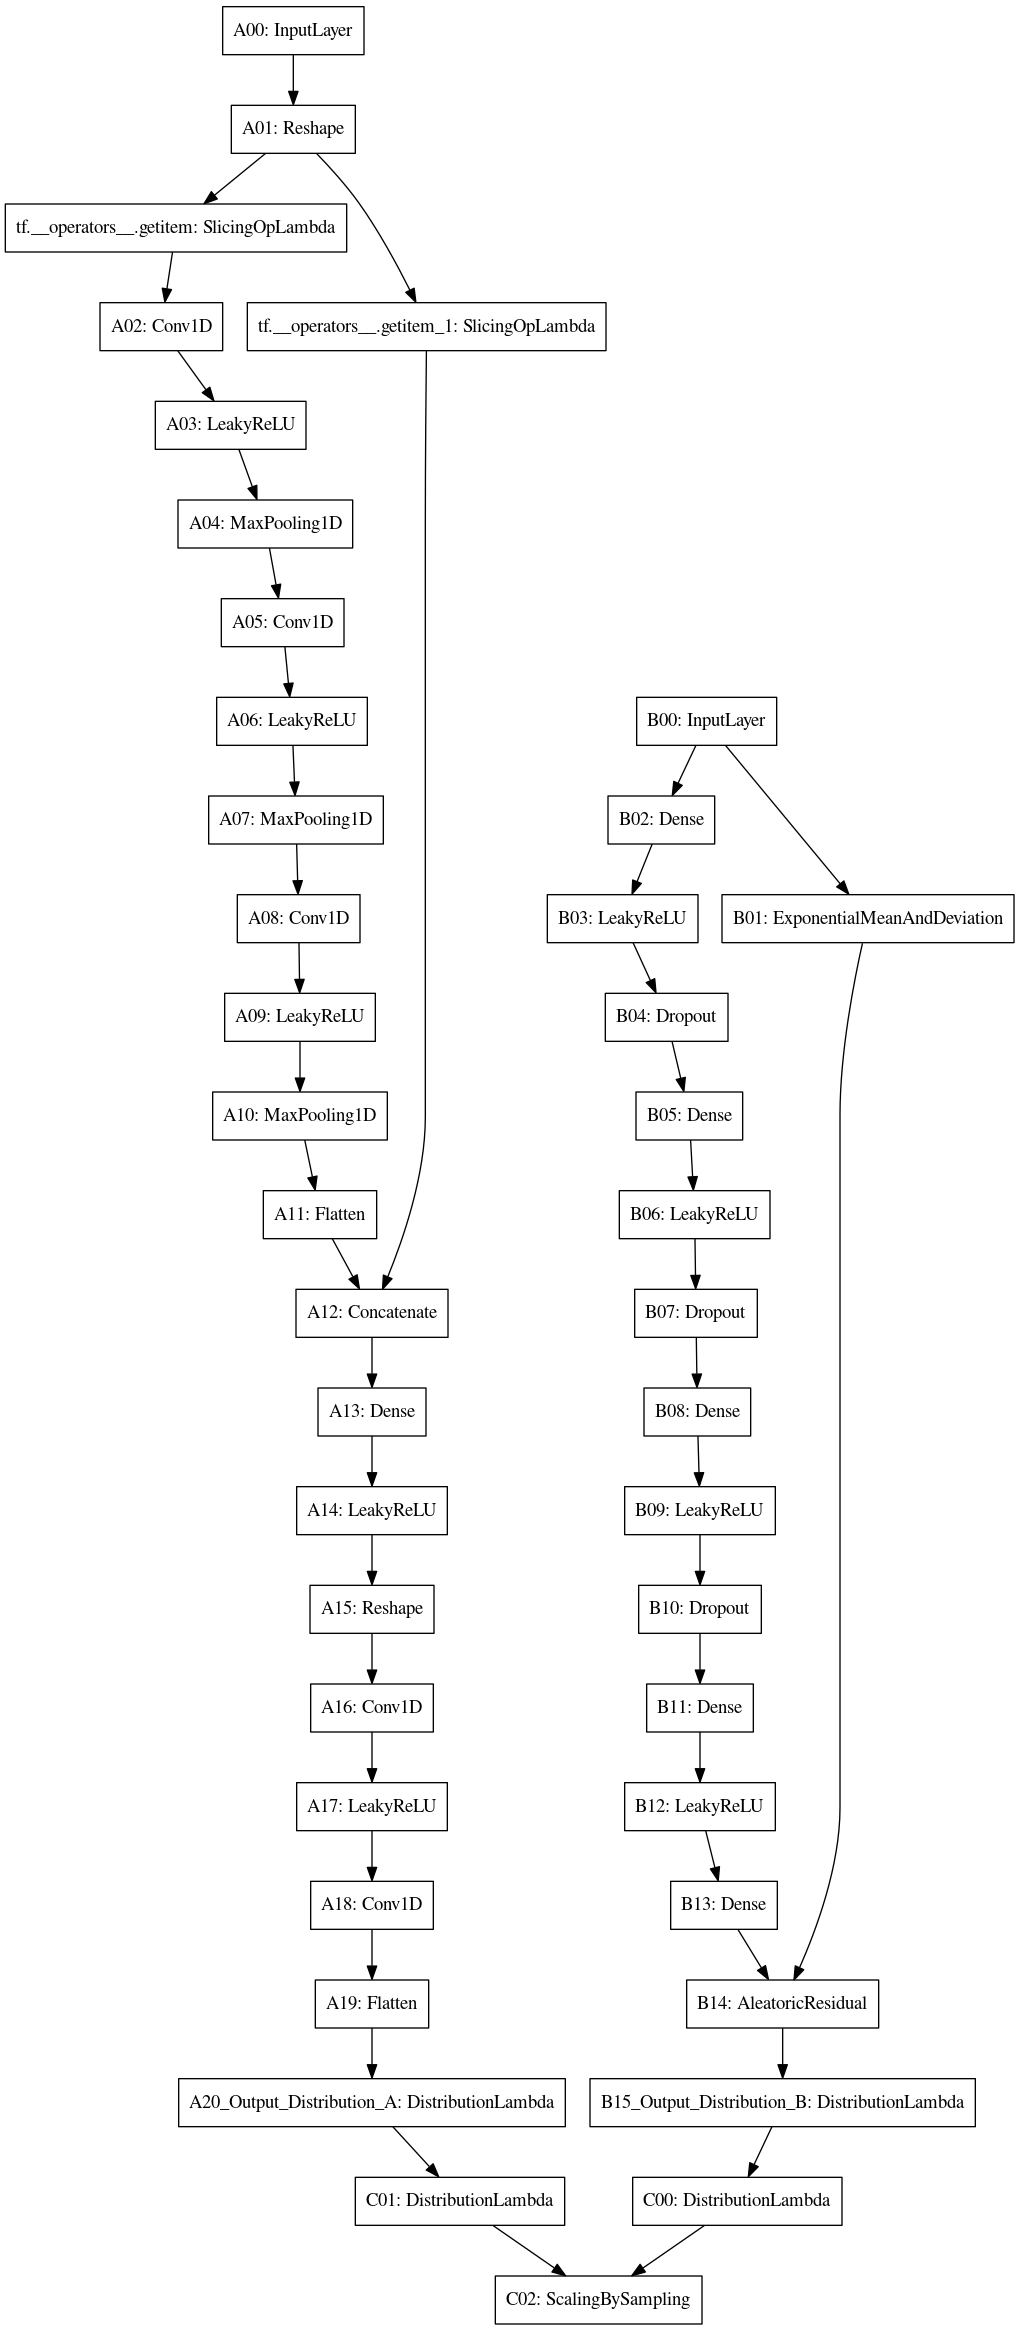

In [19]:
plot_model(model.model)

In [20]:
model.train(features)

Epoch 1/40
2757/2757 [==============================] - 18s 6ms/step - loss: 1.1041 - val_loss: -0.7341

Epoch 00001: val_loss improved from inf to -0.73412, saving model to ../models/C1_01/model_a.h5
Epoch 2/40
2757/2757 [==============================] - 17s 6ms/step - loss: -0.5631 - val_loss: -0.8884

Epoch 00002: val_loss improved from -0.73412 to -0.88842, saving model to ../models/C1_01/model_a.h5
Epoch 3/40
2757/2757 [==============================] - 17s 6ms/step - loss: -0.6705 - val_loss: -0.9630

Epoch 00003: val_loss improved from -0.88842 to -0.96298, saving model to ../models/C1_01/model_a.h5
Epoch 4/40
2757/2757 [==============================] - 17s 6ms/step - loss: -0.7273 - val_loss: -0.9653

Epoch 00004: val_loss improved from -0.96298 to -0.96525, saving model to ../models/C1_01/model_a.h5
Epoch 5/40
2757/2757 [==============================] - 17s 6ms/step - loss: -0.7594 - val_loss: -1.0108

Epoch 00005: val_loss improved from -0.96525 to -1.01082, saving model t

613/613 [==============================] - 2s 3ms/step - loss: -1.5062 - val_loss: -1.2240

Epoch 00007: val_loss did not improve from -1.24578
Epoch 8/100
613/613 [==============================] - 2s 3ms/step - loss: -1.5044 - val_loss: -1.0564

Epoch 00008: val_loss did not improve from -1.24578
Epoch 9/100
613/613 [==============================] - 2s 3ms/step - loss: -1.5294 - val_loss: -1.2665

Epoch 00009: val_loss improved from -1.24578 to -1.26645, saving model to ../models/C1_01/model_b.h5
Epoch 10/100
613/613 [==============================] - 2s 3ms/step - loss: -1.5486 - val_loss: -1.2534

Epoch 00010: val_loss did not improve from -1.26645
Epoch 11/100
613/613 [==============================] - 2s 3ms/step - loss: -1.5578 - val_loss: -1.2446

Epoch 00011: val_loss did not improve from -1.26645
Epoch 12/100
613/613 [==============================] - 2s 3ms/step - loss: -1.5650 - val_loss: -1.2127

Epoch 00012: val_loss did not improve from -1.26645
Epoch 13/100
613/613 [==

Epoch 57/100
613/613 [==============================] - 2s 3ms/step - loss: -1.7534 - val_loss: -1.4224

Epoch 00057: val_loss did not improve from -1.49013
Epoch 58/100
613/613 [==============================] - 2s 3ms/step - loss: -1.7557 - val_loss: -1.4929

Epoch 00058: val_loss improved from -1.49013 to -1.49289, saving model to ../models/C1_01/model_b.h5
Epoch 59/100
613/613 [==============================] - 2s 3ms/step - loss: -1.7523 - val_loss: -1.4322

Epoch 00059: val_loss did not improve from -1.49289
Epoch 60/100
613/613 [==============================] - 2s 3ms/step - loss: -1.7583 - val_loss: -1.4181

Epoch 00060: val_loss did not improve from -1.49289
Epoch 61/100
613/613 [==============================] - 2s 3ms/step - loss: -1.7574 - val_loss: -1.4055

Epoch 00061: val_loss did not improve from -1.49289
Epoch 62/100
613/613 [==============================] - 2s 3ms/step - loss: -1.7589 - val_loss: -1.4130

Epoch 00062: val_loss did not improve from -1.49289
Epoch 63/

In [21]:
model.evaluate()

340/340 [==============================] - 0s 952us/step - loss: -2.0043
branch A: SCORE on test data hourly:       -1.0939877033233643
branch A: SCORE on validation data hourly: -1.553483009338379
branch A: MSE on test data hourly:         0.49119991261937795
branch A: MSE on validation data hourly:   0.4766498199493749
branch B: SCORE on test data hourly:       -1.5196541547775269
branch B: SCORE on validation data hourly: -2.004277229309082
branch B: MSE on test data hourly:         0.03341136916447277
branch B: MSE on validation data hourly:   0.03278572184589366


### Plotting Prediction Results

In [22]:
def run(configuration):
    title = configuration['title']
    selected_customers = [list(customers['customer'].values).index(name) for name in configuration['customers']]
    selected_dates = [list(dates[skip:]).index(pd.to_datetime(date).date()) for date in configuration['dates']]
    extractor = FeatureExtractor(properties, selected_customers, consumptions, consumptions_scaled, 
                                 consumptions_daily_mean, weather, weather_daily_mean, weather_forecast, days)
    features = [extractor.extract(date, selected_customers) for date in dates[skip:]]
    model = PredictionModel(properties)
    model.load()
    predictions = model.predict(features)
    model.plot(predictions, consumptions, dates[skip:], selected_dates, customers, 
               selected_customers, consumptions_daily_mean, title=title)
    return

In [23]:
configurations = [
    {'customers': ['5d6fcd7cf44b0324bc6b79dc'],
     'title': 'Actual and Predicted Consumption for Customer 5d6fcd7cf44b0324bc6b79dc',
     'dates': ['2019-10-24', '2019-08-22', '2019-01-27', '2019-10-16']},
    {'customers': ['5d6fcd7cf44b0324bc6b79dc'],
     'title': 'Actual and Predicted Consumption for Customer 5d6fcd7cf44b0324bc6b79dc',
     'dates': ['2019-08-08', '2019-11-24', '2019-05-03', '2019-10-30']},
    {'customers': ['5d6fcd69f44b0324bc6b788a'],
     'title': 'Actual and Predicted Consumption for Customer 5d6fcd69f44b0324bc6b788a',
     'dates': ['2019-02-18', '2019-12-08', '2019-03-20', '2019-12-19']},
    {'customers': ['5d6fcd1df44b0324bc6b7260'],
     'title': 'Actual and Predicted Consumption for Customer 5d6fcd1df44b0324bc6b7260',
     'dates': ['2019-02-18', '2019-12-08', '2019-03-20', '2019-12-19']},
    {'customers': list(customers['customer'].iloc[I[2]].values),
     'title': 'Actual and Predicted Consumption for 31 Customers (Validation Dataset)',
     'dates': ['2019-10-20', '2019-03-16', '2019-10-13', '2019-09-19']},
    {'customers': list(customers['customer'].iloc[I[0]].values),
     'title': 'Actual and Predicted Consumption for 252 Customers (Training Dataset)',
     'dates': ['2019-10-20', '2019-03-16', '2019-10-13', '2019-09-19']},
]

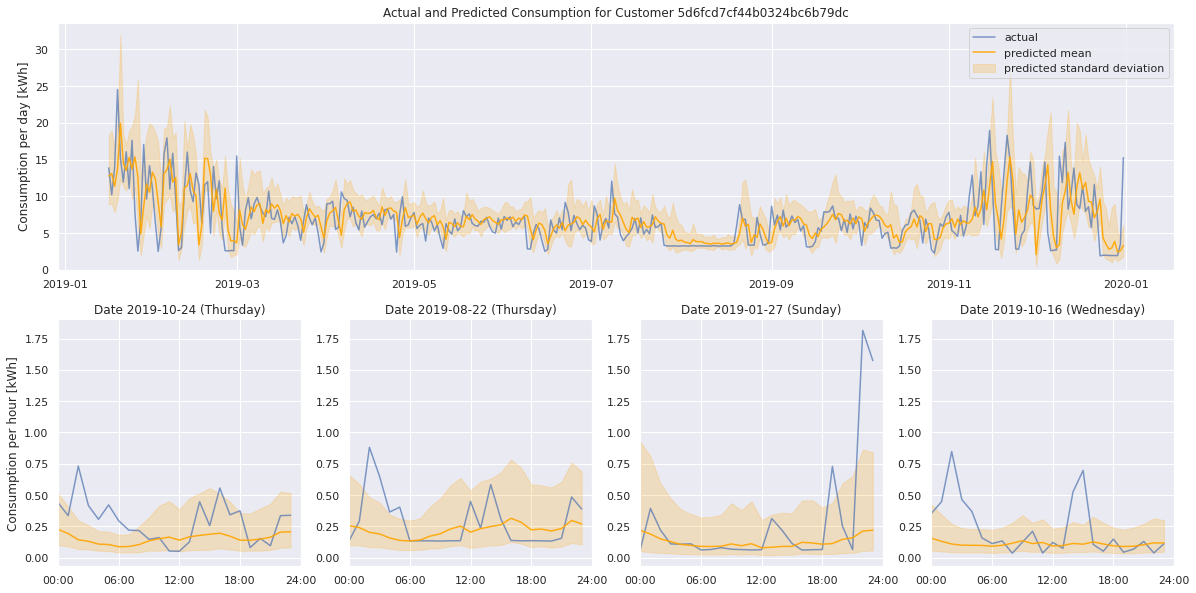

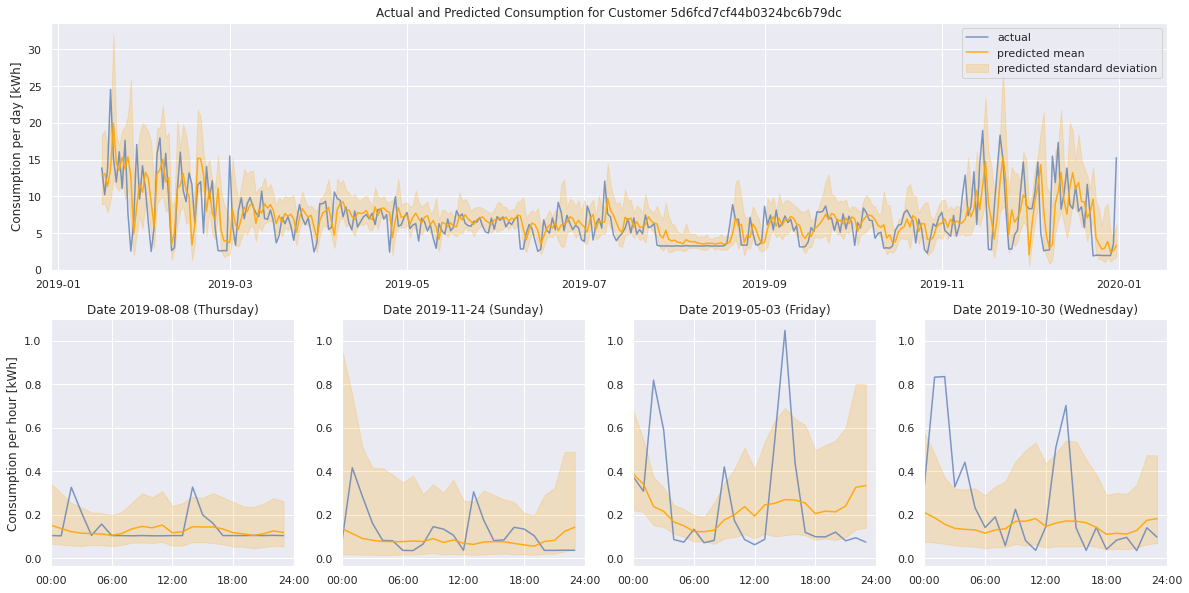

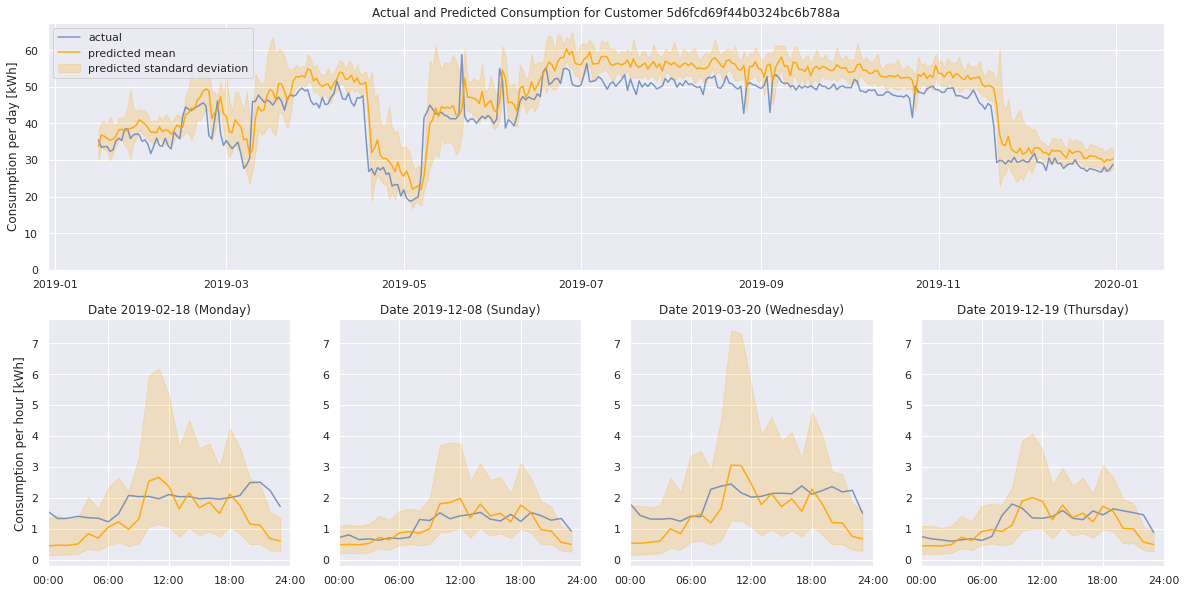

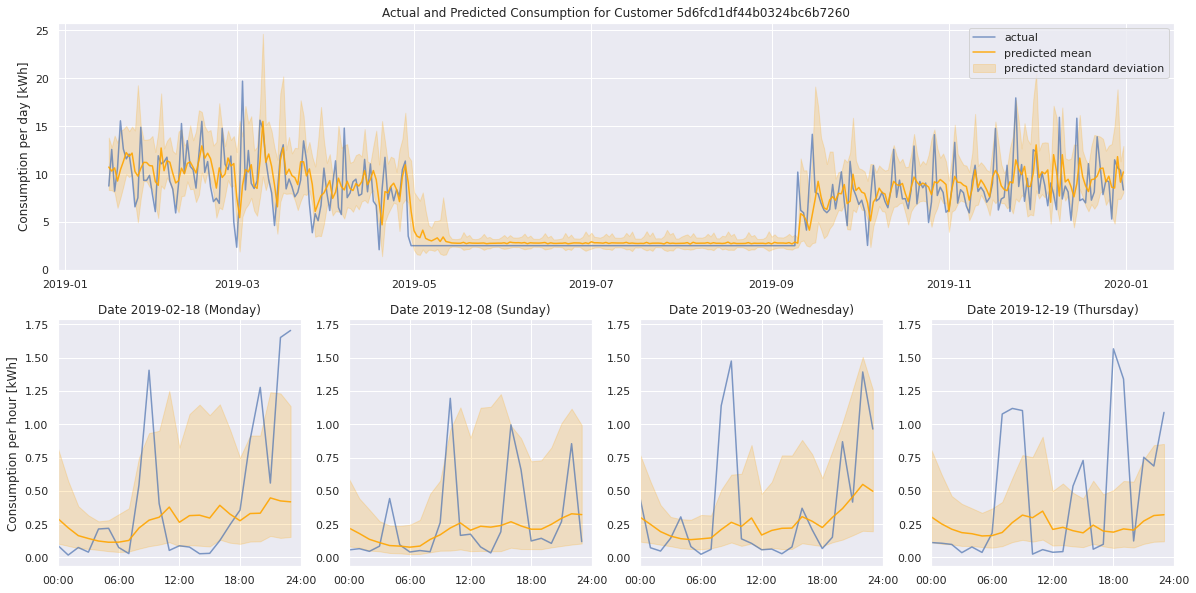

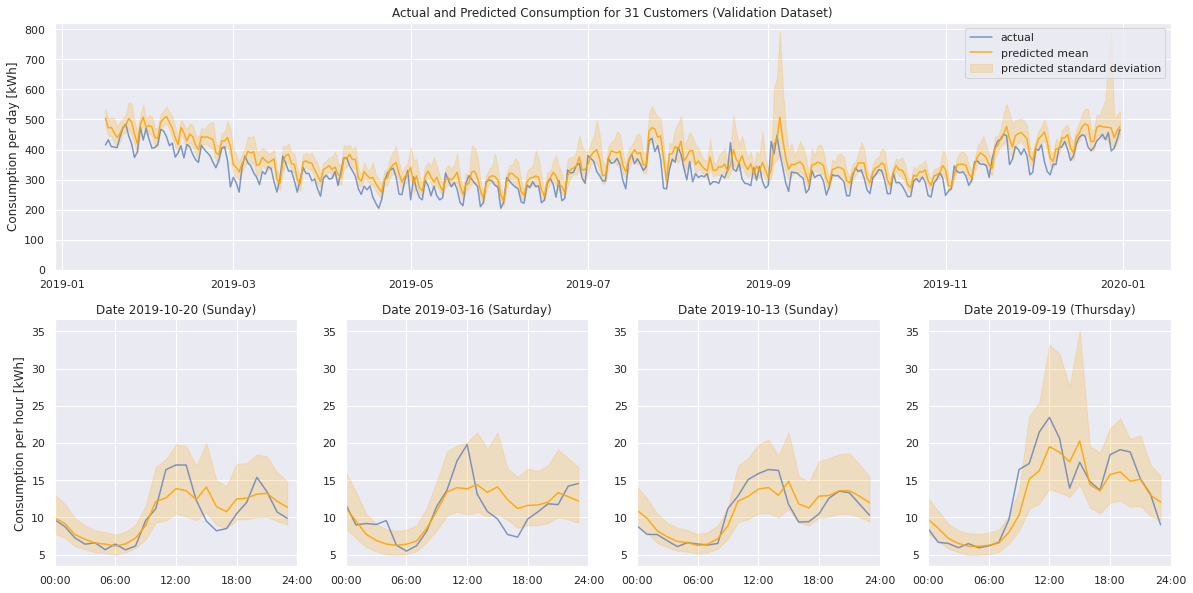

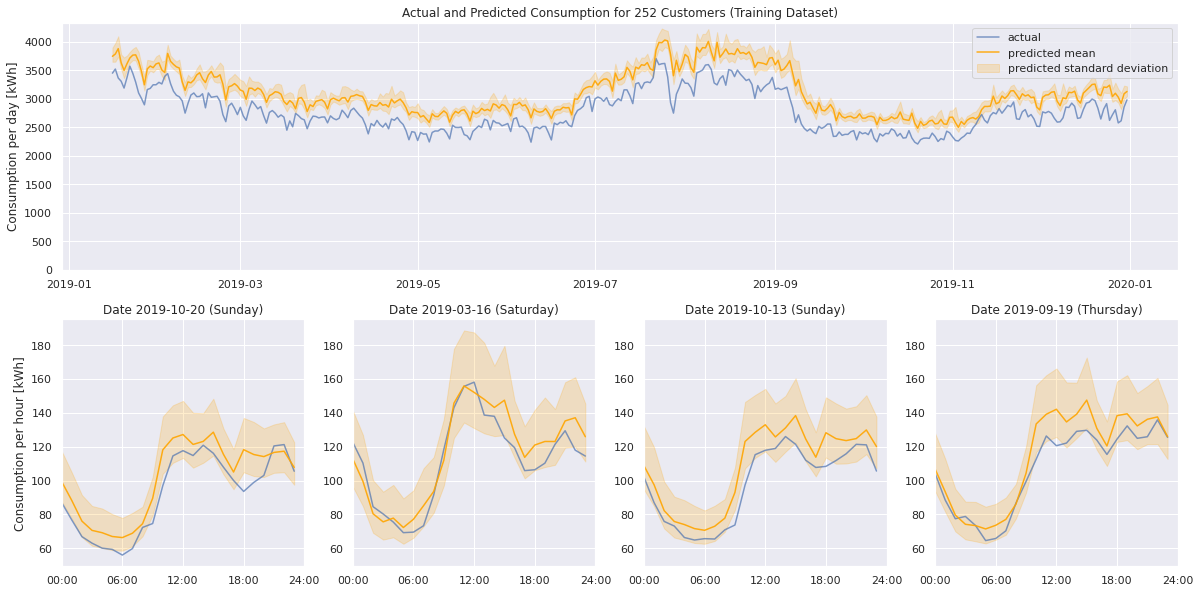

In [24]:
_ = [run(configuration) for configuration in configurations]